#prepare

## check gpu

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices());

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6697925682800357164
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14328594432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17125238332108409806
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## module import

In [2]:
# base
import os
import glob
import shutil
import numpy as np
import math
import pickle
from tqdm.notebook import tqdm
import gc
import matplotlib.pyplot as plt

In [3]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import models, layers, optimizers
from keras import backend

In [4]:
# util machine learning
import pandas as pd
import sklearn
import skimage

In [5]:
# abstract
from abc import ABC, abstractmethod

## git import

In [6]:
!git clone https://github.com/kc71486/autonomous_hw3.git

Cloning into 'autonomous_hw3'...
remote: Enumerating objects: 51940, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 51940 (delta 0), reused 9 (delta 0), pack-reused 51931
Receiving objects: 100% (51940/51940), 299.46 MiB | 16.53 MiB/s, done.
Updating files: 100% (51892/51892), done.


## switch working directory

In [6]:
%cd autonomous_hw3

/content/autonomous_hw3


# preprocess

codes in this block area is meant to execute without main

## resize image

In [ ]:
def img_resize(src_dataset_path, dest_dataset_path, new_shape):
  #remove old if exist
  if os.path.isdir(dest_dataset_path):
    shutil.rmtree(dest_dataset_path);
  os.makedirs(dest_dataset_path);
  shutil.copyfile(os.path.join(src_dataset_path, 'Train.csv'),
                  os.path.join(dest_dataset_path, 'Train.csv'));
  shutil.copyfile(os.path.join(src_dataset_path, 'Test.csv'),
                  os.path.join(dest_dataset_path, 'Test.csv'));
  os.makedirs(os.path.join(dest_dataset_path, 'Train'));
  os.makedirs(os.path.join(dest_dataset_path, 'Test'));
  for i in range(43):
    os.makedirs(os.path.join(dest_dataset_path, 'Train', str(i)));
  df_train = pd.read_csv(src_dataset_path + 'Train.csv');
  for imgpath in df_train['Path']:
    oldimg = skimage.io.imread(os.path.join(src_dataset_path, imgpath));
    newimg = skimage.transform.resize(oldimg, new_shape, anti_aliasing=True);
    skimage.io.imsave(os.path.join(dest_dataset_path, imgpath),
                      skimage.img_as_ubyte(newimg), check_contrast=False);
  df_test = pd.read_csv(src_dataset_path + 'Test.csv');
  for imgpath in df_test['Path']:
    oldimg = skimage.io.imread(os.path.join(src_dataset_path, imgpath));
    newimg = skimage.transform.resize(oldimg, new_shape, anti_aliasing=True);
    skimage.io.imsave(os.path.join(dest_dataset_path, imgpath),
                      skimage.img_as_ubyte(newimg), check_contrast=False);

In [ ]:
#img_resize('./dataset/', './dataset_lenet/', (28, 28, 3));

# main

## define global constants

In [7]:
DATASET_PATH = './dataset/'
BATCH_SIZE = 16;
EPOCHS = 10;
CATEGORIES = 43;

In [56]:
np.random.seed(1276)

## define model

In [57]:
class ModelBase(keras.Sequential, ABC):
  def __init__(self):
    super().__init__();
  @abstractmethod
  def inputShape(self):
    pass;
  def compile(self):
    # default compile option
    super().compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']);
  def fit(self, trainSeq, validSeq):
    # override fit option
    return super().fit(x=trainSeq, batch_size=BATCH_SIZE, epochs=EPOCHS,
                        verbose=1, validation_data=validSeq);

In [58]:
class ModelLenet(ModelBase):
  model = None;
  def __init__(self):
    super().__init__();
    # layer 1
    super().add(layers.Conv2D(filters=6, kernel_size=(5, 5), strides = (1, 1), padding = 'valid',
                            activation='relu', input_shape=self.inputShape()));
    super().add(layers.MaxPooling2D(pool_size=(2, 2)));
    # layer 2
    super().add(layers.Conv2D(filters=16, kernel_size=(5, 5)));
    super().add(layers.MaxPooling2D(pool_size=(2, 2)));
    # layer 3
    super().add(layers.Flatten());
    super().add(layers.Dense(units=120, activation='relu'));
    # layer 4
    super().add(layers.Dense(units=84, activation='relu'));
    super().add(layers.Dropout(rate=0.2));
    # layer 5
    super().add(layers.Dense(units=CATEGORIES, activation='softmax'));
  def inputShape(self):
    return (32, 32, 3);

In [59]:
# somehow bugged, only 5% accuracy
class ModelAlexnet(ModelBase):
  model = None;
  def __init__(self):
    super().__init__();
    # layer 1
    super().add(layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid',
                            activation='relu', input_shape=self.inputShape()));
    #super().add(layers.BatchNormalization());
    super().add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)));
    # layer 2
    super().add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same',
                            activation='relu'));
    #super().add(layers.BatchNormalization());
    super().add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)));
    # layer 3
    super().add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same',
                            activation='relu'));
    # layer 4
    super().add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same',
                            activation='relu'));
    # layer 5
    super().add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
                            activation='relu'));
    super().add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)));
    # layer 6
    super().add(layers.Flatten());
    super().add(layers.Dense(units=4096, activation='relu'));
    super().add(layers.Dropout(rate=0.5));
    # layer 7
    super().add(layers.Dense(units=4096, activation='relu'));
    super().add(layers.Dropout(rate=0.5));
    # layer 8
    super().add(layers.Dense(units=CATEGORIES, activation='softmax'));
  def inputShape(self):
    return (227, 227, 3);

## data loading and augmentation

In [12]:
# image dataloader
class ImageSequence(keras.utils.Sequence):
  def __init__(self, imgpath: list, label: list, batch_size: int, model_input_size=None):
    self.path = imgpath;
    self.label = label;
    self.batch_size = batch_size;
    self.input_size = model_input_size;

  def __len__(self):
    return math.ceil(len(self.path) / self.batch_size);

  def __getitem__(self, idx: int):
    low = idx * self.batch_size;
    # Cap upper bound at array length
    high = min(low + self.batch_size, len(self.path));
    batch_path = self.path[low:high];
    batch_label = self.label[low:high];
    if self.input_size is None:
      return np.array([skimage.img_as_float(
          skimage.io.imread(os.path.join(DATASET_PATH, file_name)))
        for file_name in batch_path]), np.array(batch_label)
    else:
      return np.array([skimage.transform.resize(
          skimage.io.imread(os.path.join(DATASET_PATH, file_name)),
          self.input_size, anti_aliasing=True)
        for file_name in batch_path]), np.array(batch_label);

In [13]:
# object dataloader
class ObjectSequence(keras.utils.Sequence):
  def __init__(self, objpath: str, batch_size: int):
    self.batch_size = batch_size;
    self.path = objpath;
    self.objcount = 0;
    for filename in glob.glob(os.path.join(objpath, '*')):
      self.objcount += 1;

  def __len__(self):
    return self.objcount;

  def __getitem__(self, idx):
    batch_file = os.path.join(self.path, str(idx));
    with open(batch_file, mode='rb') as f:
      img = pickle.load(f);
      label = pickle.load(f);
    return img, label;

In [14]:
def trainValidShuffleSplit(df: pd.DataFrame, Train_ratio: float):
  seperatePoint = int(len(df) * Train_ratio);
  dfshuffle = sklearn.utils.shuffle(df);
  trainImage = dfshuffle['Path'][:seperatePoint];
  validImage = dfshuffle['Path'][seperatePoint:];
  trainLabel = dfshuffle['ClassId'][:seperatePoint];
  validLabel = dfshuffle['ClassId'][seperatePoint:];
  return trainImage, validImage, trainLabel, validLabel;

In [15]:
def SaveImageAsObject(seq, path: str):
  # remove old content
  for filename in glob.glob(os.path.join(path, '*')):
    try:
        os.unlink(filename);
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (filename, e));
  # dump new content
  print("saving image...");
  for idx in tqdm(range(len(seq))):
    batch_file = os.path.join(path, str(idx));
    with open(batch_file, 'wb') as f:
      img, label = seq[idx];
      pickle.dump(img, f);
      pickle.dump(label, f);

## display plot

In [16]:
def plotHistory(history, modelName: str):
  plt.suptitle(modelName);
  plt.subplot(121);
  plt.plot(history.history['accuracy'], '-o');
  plt.plot(history.history['val_accuracy'], '-o');
  plt.title('Training and validation accuracy');
  plt.xlabel('Epochs');
  plt.ylabel('Accuracy');
  plt.legend(['Training accuracy', 'Validation accuracy']);
  plt.subplot(122);
  plt.plot(history.history['loss'], '-o');
  plt.plot(history.history['val_loss'], '-o');
  plt.title('Training and validation loss');
  plt.xlabel('Epochs');
  plt.ylabel('Loss');
  plt.legend(['Training accuracy', 'Validation loss']);
  plt.tight_layout();
  plt.show();

## reset session

In [17]:
# Reset Keras Session
def reset_keras():
    sess = backend.get_session();
    backend.clear_session();
    sess.close();
    sess = backend.get_session();

    try:
        del model
    except:
        pass

    print(gc.collect()); # if it does something you should see a number as output

    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    backend.set_session(tf.compat.v1.Session(config=config))

## execute code

In [77]:
# accuracy 98%

model = ModelAlexnet();
model.summary();

Model: "model_alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)     

In [64]:
# accuracy 98%

#model = ModelLenet();
#model.summary();

Model: "model_lenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               

In [ ]:
# load model (Alexnet)

#model = keras.models.load_model('./weight/alexnet.w');
#model.summary();

In [70]:
df = pd.read_csv(os.path.join(DATASET_PATH, 'Train.csv'));
trainImage, validImage, trainLabel, validLabel = trainValidShuffleSplit(df, 0.8);
trainLabel_catagory = keras.utils.to_categorical(trainLabel, CATEGORIES);
validLabel_catagory = keras.utils.to_categorical(validLabel, CATEGORIES)
trainSequence_image = ImageSequence(trainImage, trainLabel_catagory, BATCH_SIZE, model.inputShape());
validSequence_image = ImageSequence(validImage, validLabel_catagory, BATCH_SIZE, model.inputShape());

In [43]:
trainObj_path = './local/obj_sequence/train/';
validObj_path = './local/obj_sequence/valid/';

In [71]:
SaveImageAsObject(trainSequence_image, trainObj_path);
SaveImageAsObject(validSequence_image, validObj_path);

saving image...


  0%|          | 0/1961 [00:00<?, ?it/s]

saving image...


  0%|          | 0/491 [00:00<?, ?it/s]

In [72]:
trainSequence = ObjectSequence(trainObj_path, BATCH_SIZE);
validSequence = ObjectSequence(validObj_path, BATCH_SIZE);

In [73]:
model.compile();
history = model.fit(trainSeq=trainSequence, validSeq=validSequence);

Epoch 1/10
1462/1961 [=====================>........] - ETA: 45s - loss: 3.5046 - accuracy: 0.0531

KeyboardInterrupt: ignored

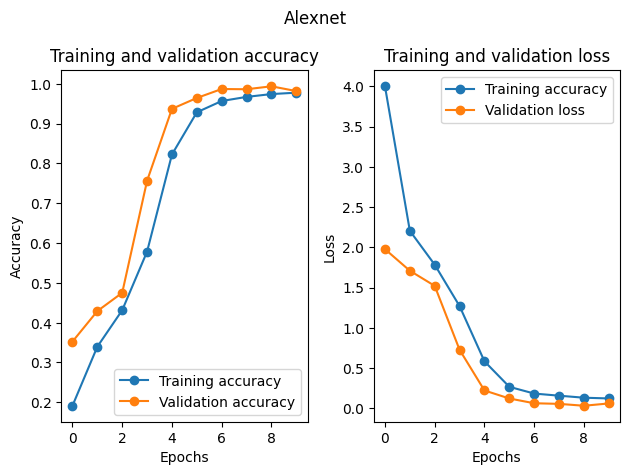

In [60]:
plotHistory(history, 'Alexnet');

In [ ]:
savemodel_name = 'lenet';

model.save_weights('./local/weight/' + savemodel_name);

%cd './local/weight/'
shutil.make_archive(savemodel_name, 'zip', '.');
%cd ../..

In [76]:
reset_keras();

3836


# cleanup

## git commit and push

In [ ]:
#manual upload file
f = open("../remotepath.txt", "r");
git_email = f.readline();
git_username = f.readline();
remote_path = f.readline();


In [ ]:
!git config --global user.email {git_email}
!git config --global user.name {git_username}
!git remote set-url origin {remote_path}

In [ ]:
!git add "*"

In [ ]:
!git commit -m "save weight"

[master 5789e725] save alexnet weight
 2 files changed, 0 insertions(+), 0 deletions(-)
 rename {weight => local/weight}/.gitignore (100%)
 delete mode 100644 weight/alexnet.zip


In [ ]:
!git push origin master

Enumerating objects: 20, done.
Counting objects: 100% (20/20), done.
Delta compression using up to 2 threads
Compressing objects: 100% (14/14), done.
Writing objects: 100% (18/18), 1.04 GiB | 15.02 MiB/s, done.
Total 18 (delta 3), reused 2 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 1 local object.
remote: error: Trace: e4eca8b2fe35ec68d98930e0bc86a48f0f1d37cf0a39ba7a756a39c14adb1752
remote: error: See https://gh.io/lfs for more information.
remote: error: File weight/alexnet.w/variables/variables.data-00000-of-00001 is 669.06 MB; this exceeds GitHub's file size limit of 100.00 MB
remote: error: File weight/alexnet.zip is 535.39 MB; this exceeds GitHub's file size limit of 100.00 MB
remote: error: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/kc71486/autonomous_hw3
 ! [remote rejected]   master -> master (pre-receive hook declined)
error: failed to push some refs to 'https://ghp_jCs8wBmo9Vq